In [1]:
import numpy as np
import os
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPool2D, Concatenate, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from time import time

from tensorflow.keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
def H(  inputs, num_filters , dropout_rate ):
    x = tf.keras.layers.BatchNormalization( epsilon=eps )( inputs )
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate )(x)
    return x

In [3]:
def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = tf.keras.layers.BatchNormalization( epsilon=eps )(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = tf.keras.layers.Conv2D( np.floor( compression_factor * num_feature_maps ).astype( np.int ) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

In [4]:
def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

In [5]:
input_shape = ( 32 , 32 , 3) 
num_blocks = 3
num_layers_per_block = 4
growth_rate = 16
dropout_rate = 0.4
compress_factor = 0.5
eps = 1.1e-5

num_filters = 16

inputs = tf.keras.layers.Input( shape=input_shape )
x = tf.keras.layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , use_bias=False, kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )( inputs )

for i in range( num_blocks ):
    x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
    x = transition(x, num_filters , compress_factor , dropout_rate )

x = tf.keras.layers.GlobalAveragePooling2D()( x ) 
x = tf.keras.layers.Dense( 10 )( x ) # Num Classes for CIFAR-10
outputs = tf.keras.layers.Activation( 'softmax' )( x )

/home/agratia/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [6]:
model = Model( inputs , outputs )
model.compile( loss=tf.keras.losses.sparse_categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam( lr=0.0001 ) ,metrics=[ 'acc' ])
model.summary()
print(len(model.layers))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 30, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 30, 30, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

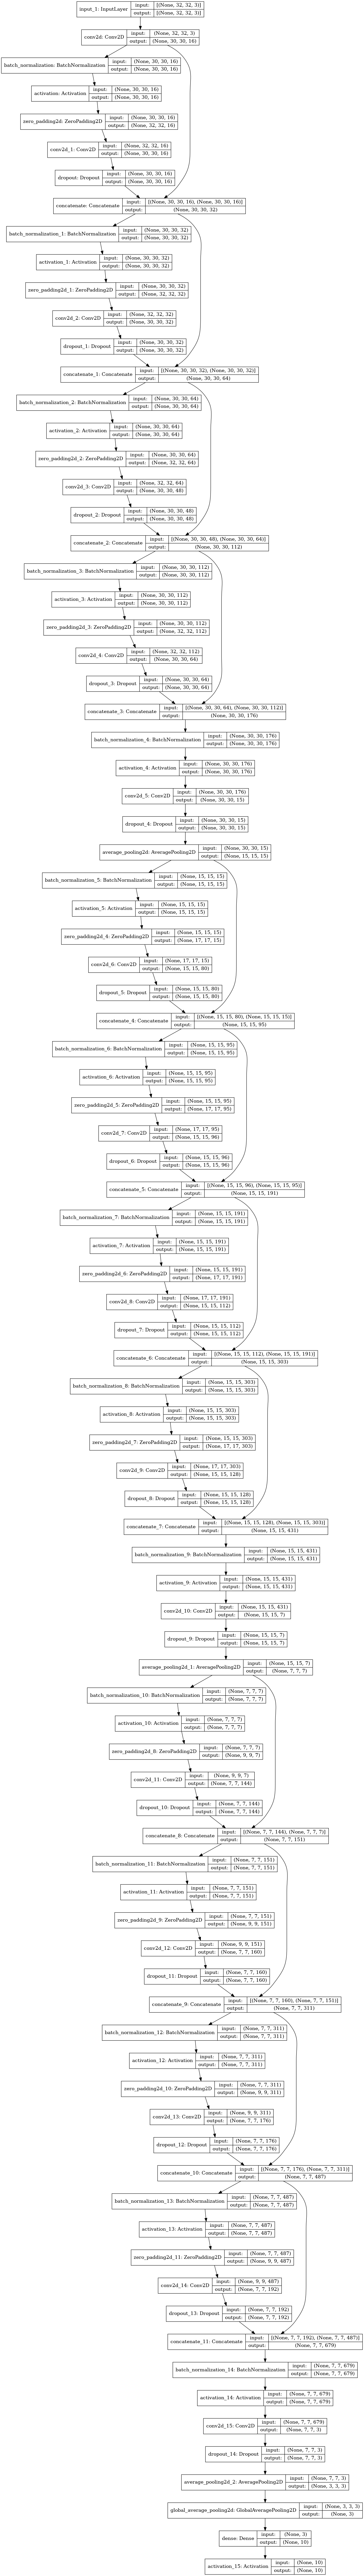

In [7]:
plot_model(model, show_shapes=True, to_file="densenet.png")

In [8]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1)
list_cb = [es]

In [10]:
start = time()
model.fit( train_x , train_y , epochs=50, batch_size=1024, validation_split=0.3, callbacks=list_cb)
training_time = time()-start

Epoch 1/50
35/35 [==============================] - 936s 26s/step - loss: 2.3391 - acc: 0.1220 - val_loss: 2.2968 - val_acc: 0.1617
Epoch 2/50
35/35 [==============================] - 748s 21s/step - loss: 2.2462 - acc: 0.2021 - val_loss: 2.2847 - val_acc: 0.1244
Epoch 3/50
35/35 [==============================] - 713s 20s/step - loss: 2.2026 - acc: 0.2165 - val_loss: 2.2756 - val_acc: 0.1291
Epoch 4/50
35/35 [==============================] - 644s 18s/step - loss: 2.1754 - acc: 0.2265 - val_loss: 2.2552 - val_acc: 0.1621
Epoch 5/50
35/35 [==============================] - 765s 22s/step - loss: 2.1512 - acc: 0.2422 - val_loss: 2.2746 - val_acc: 0.1599
Epoch 6/50
35/35 [==============================] - 777s 22s/step - loss: 2.1278 - acc: 0.2530 - val_loss: 2.2683 - val_acc: 0.1693
Epoch 7/50
35/35 [==============================] - 767s 22s/step - loss: 2.1005 - acc: 0.2646 - val_loss: 2.2633 - val_acc: 0.1798
Epoch 8/50
35/35 [==============================] - 773s 22s/step - loss: 2.

In [11]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 20s 64ms/step - loss: 2.0946 - acc: 0.4428


[2.094648838043213, 0.44279998540878296]

In [12]:
model.evaluate(train_x, train_y)

1563/1563 [==============================] - 97s 62ms/step - loss: 2.0254 - acc: 0.4484


[2.0253775119781494, 0.44835999608039856]

In [13]:
training_time

36605.10148334503